In [274]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

## Hyperparams

In [275]:
n_epochs = 3
batch_size = 256

n_features = 128
projection_dim = 128
n_layers = 4

weight_decay = 1e-4
max_lr = 0.01
lr = 0.001

n_channels = 5
seq_len = 256
n_classes = 10

show_acc_freq = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [276]:
data_dir = "./data/"
# O1 O2 T5 T6
# bandpass 5-95 Hz

## Load Data

In [277]:
import datasets

d_train = datasets.load_from_disk(data_dir + "eeg_mnist_train")
d_test = datasets.load_from_disk(data_dir + "eeg_mnist_test")

In [278]:
# for i in tqdm(range(len(d_train["pixel_values"]) - 1, -1, -1)):
#     if len(d_train["pixel_values"][i]) != 256:
#         print("popping", i)
#         d_train["pixel_values"].pop(i)
#         d_train["labels"].pop(i)

In [279]:
train_eegs = torch.tensor(d_train["pixel_values"])
train_labels = torch.tensor(d_train["label"])

test_eegs = torch.tensor(d_test["pixel_values"])
test_labels = torch.tensor(d_test["label"])

In [280]:
print(train_eegs.shape, train_eegs.dtype)
print(train_labels.shape, train_labels.dtype)

torch.Size([10436, 256, 5]) torch.float32
torch.Size([10436]) torch.int64


In [281]:
from torch.utils.data import Dataset
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, WindowOperations, WaveletTypes

class EEGDataset(Dataset):
    def __init__(self, eegs, labels):
        self.eegs = eegs
        self.labels = labels

    def __getitem__(self, idx):
        eeg = self.eegs[idx]
        label = self.labels[idx]
        
        eeg = np.ascontiguousarray(eeg.numpy().transpose(), dtype=np.float64)
        sampling_rate = 128

        for channel in range(n_channels):    
            DataFilter.detrend(eeg[channel], DetrendOperations.CONSTANT.value)
            DataFilter.perform_bandpass(eeg[channel], sampling_rate, 0.5, 55.0, 2,
                                    FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
            
            # demo for wavelet transforms
            # wavelet_coeffs format is[A(J) D(J) D(J-1) ..... D(1)] where J is decomposition level, A - app coeffs, D - detailed coeffs
            # lengths array stores lengths for each block
            wavelet_coeffs, lengths = DataFilter.perform_wavelet_transform(eeg[channel], WaveletTypes.DB4, 3)
            app_coefs = wavelet_coeffs[0: lengths[0]]
            detailed_coeffs_first_block = wavelet_coeffs[lengths[0]: lengths[1]]
            restored_data = DataFilter.restore_data_from_wavelet_detailed_coeffs(eeg[channel], WaveletTypes.DB4, 3, 2)
            eeg[channel] = restored_data

        eeg = torch.from_numpy(eeg.transpose()).float()
        
        return eeg, label

    def __len__(self):
        return len(self.eegs)

train_data = EEGDataset(train_eegs, train_labels)
test_data = EEGDataset(test_eegs, test_labels)

In [282]:
eeg, label = train_data[0]
print(eeg.shape, label)

torch.Size([256, 5]) tensor(6)


## Define Network

In [283]:
from models import EEGFeatNet, ClassificationHead

eeg = torch.randn((batch_size, seq_len, n_channels)).to(device)
model = EEGFeatNet(n_channels=n_channels, n_features=n_features, projection_dim=projection_dim, num_layers=n_layers).to(device)
classifier = ClassificationHead(hidden_size=projection_dim).to(device)

proj = model(eeg)
pred = classifier(proj)
print(pred.shape)

torch.Size([256, 10])


In [284]:
f"All Parameters: {sum(p.numel() for p in model.parameters())}"

'All Parameters: 481792'

## Dataloaders

In [285]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([256])


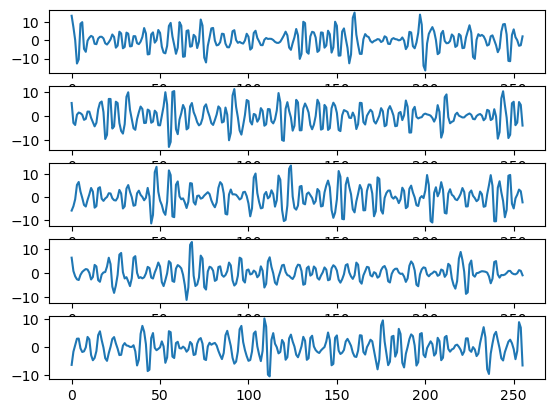

In [286]:
import matplotlib.pyplot as plt

for eegs, label in train_loader:
    eegs = eegs.to(device)
    proj = model(eegs)
    print(eegs[0, :, 0].shape)

    for i in range(n_channels):
        plt.subplot(n_channels, 1, i + 1)
        plt.plot(eegs[i, :, 0].to("cpu"))

    break

## Train Loop for Classifier

In [287]:
def train(model, classifier, optimizer, scheduler, train_loader, saving_loss=False):
    model.train()
    classifier.train()

    tq = tqdm(train_loader)
    total_loss = 0
    for batch_idx, (eegs, labels) in enumerate(tq):
        eegs = eegs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(eegs)
        y_pred = classifier(embeddings)

        loss = F.cross_entropy(y_pred, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if saving_loss:
            total_loss += loss.detach().item()
            
    if saving_loss:
        print(f"CE Loss: {total_loss}")

In [288]:
def eval(model, classifier, loader):
    model.eval()
    classifier.eval()

    tq = tqdm(loader)
    correct = 0
    total = 0
    for batch_idx, (eegs, labels) in enumerate(tq):
        eegs = eegs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = model(eegs)
            y_pred = classifier(embeddings)


        _, predicted = torch.max(y_pred.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total


In [289]:
model = EEGFeatNet(n_channels=n_channels, n_features=n_features, projection_dim=projection_dim, num_layers=n_layers).to(device)
classifier = ClassificationHead(hidden_size=projection_dim, num_classes=n_classes).to(device)

parameters = list(model.parameters()) + list(classifier.parameters())
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=weight_decay)

In [290]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=n_epochs)

In [291]:
for epoch in range(n_epochs):
    if epoch % show_acc_freq == 0:
        saving_loss = True
    else:
        saving_loss = False
    train(model, classifier, optimizer, scheduler, train_loader, saving_loss)

100%|██████████| 41/41 [00:07<00:00,  5.71it/s]


CE Loss: 94.57328414916992


100%|██████████| 41/41 [00:07<00:00,  5.45it/s]


CE Loss: 94.59650039672852


100%|██████████| 41/41 [00:07<00:00,  5.23it/s]

CE Loss: 94.43925952911377


In [293]:
eval(model, classifier, test_loader)

100%|██████████| 41/41 [00:06<00:00,  6.09it/s]


0.10329628210042162

## Train Loop for Embedding

In [ ]:
from visualization import K_means

def train(epoch, model, optimizer, loss_fn, miner, train_dataloader):
    tq = tqdm(train_dataloader)
    for batch_idx, (eeg, label) in enumerate(tq, start=1):
        eeg    = eeg.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        x_proj = model(eeg)

        hard_pairs = miner(x_proj, labels)
        loss = loss_fn(x_proj, labels, hard_pairs)
        
        loss.backward()
        optimizer.step()

        running_loss = running_loss + [loss.detach().cpu().numpy()]
                
        tq.set_description('Train:[{}, {:0.3f}]'.format(epoch, loss.item()))

    if (epoch % vis_freq) == 0:
        for batch_idx, (eeg, labels) in enumerate(tqdm(train_dataloader)):
            eeg, labels = eeg.to(device), labels.to(device)
            with torch.no_grad():
                x_proj = model(eeg)
            
            eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
            
            labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()

        ### compute k-means score and Umap score on the text and image embeddings
        k_means = K_means(n_clusters=n_classes)
        clustering_acc_proj = k_means.transform(eeg_featvec_proj, labels_array)
        print("[Epoch: {}, Train KMeans score Proj: {}]".format(epoch, clustering_acc_proj))

    return running_loss

In [ ]:
from pytorch_metric_learning import miners, losses, distances

model = EEGFeatNet(n_channels=n_channels, n_features=n_features, projection_dim=projection_dim).to(device)
optimizer = torch.optim.AdamW(list(model.parameters()), lr=lr, weight_decay=weight_decay)

# miner = miners.MultiSimilarityMiner()
# loss_fn = losses.TripletMarginLoss()
margin = 0.2
distance = distances.LpDistance()
loss_fn = losses.TripletMarginLoss(margin, distance=distance)
miner = miners.TripletMarginMiner(margin, "semihard", distance=distance)

In [ ]:
if device == "cuda":
    torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs):
    running_train_loss = train(epoch, model, optimizer, loss_fn, miner, train_loader)

100%|██████████| 41/41 [00:00<00:00, 114.46it/s]


[Epoch: 0, Train KMeans score Proj: 0.112878497508624]


100%|██████████| 41/41 [00:00<00:00, 113.60it/s]


[Epoch: 10, Train KMeans score Proj: 0.11144116519739364]


100%|██████████| 41/41 [00:00<00:00, 117.05it/s]


[Epoch: 20, Train KMeans score Proj: 0.11057876581065543]


100%|██████████| 41/41 [00:00<00:00, 114.58it/s]


[Epoch: 30, Train KMeans score Proj: 0.11115369873514756]


100%|██████████| 41/41 [00:00<00:00, 119.88it/s]


[Epoch: 40, Train KMeans score Proj: 0.10415868148715983]


100%|██████████| 41/41 [00:00<00:00, 119.86it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 50, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 118.33it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 60, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 119.99it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 70, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 117.74it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 80, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 115.83it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 90, Train KMeans score Proj: 0.10367957071674971]


Train:[99, 0.001]: 100%|██████████| 41/41 [00:00<00:00, 49.92it/s]
